# Chapter 6
# Statistical Machine Learning

import required _Python_ packages

In [1]:
import math
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns

from pathlib import Path
from collections import defaultdict
from itertools import product


from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


%matplotlib inline

no display found. Using non-interactive Agg backend

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [3]:
LOAN200_CSV = DATA / 'loan200.csv'
LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'

Set this if the notebook crashes in the XGBoost part.

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


## K-Nearest Neighbors
### A Small Example: Predicting Loan Default

In [5]:
test = pd.read_csv(LOAN200_CSV)

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   outcome            201 non-null    object 
 1   payment_inc_ratio  201 non-null    float64
 2   dti                201 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.8+ KB


In [6]:
# The scikit-learn package provides a fast and efficient implementation of KNN
loan200 = pd.read_csv(LOAN200_CSV)
predictors = ['payment_inc_ratio', 'dti']
outcome = 'outcome'

newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(newloan)
print(knn.predict_proba(newloan))

[[0.45 0.55]]


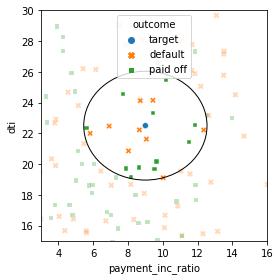

Figure 6-2. KNN prediction of loan default using two variables: debt-to-income ratio and loan-payment-to-income ratio


In [7]:
nbrs = knn.kneighbors(newloan)
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome',
                   hue='outcome', data=loan200, alpha=0.3, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome',
                   hue='outcome',
                   data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1,:]]),
                   ax=ax, legend=False)
ellipse =Ellipse(xy=newloan.values[0],
                width=2 * maxDistance, height=2 * maxDistance,
                edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()
print("Figure 6-2. KNN prediction of loan default using two variables: debt-to-income ratio and loan-payment-to-income ratio")

gives a visual display of this example. The new loan to be predicted is the cross in the middle. The squares (paid off) and circles (default) are the training data.The large black circle shows the boundary of the nearest 20 points. In this case, 9 defaulted loans lie within the circle, as compared with 11 paid-off loans. Hence the predicted outcome of the loan is paid off. Note that if we consider only three nearest neighbors, the prediction would be that the loan defaults.

## Standardization (Normalization, Z-Scores)

In [8]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

loan_data.head(10)

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55
5,6,Charged Off,21000,36 months,105000,13.22,8.01977,32135,90.3,debt_consolidation,...,1,1,7,5.8,default,11,debt_consolidation,RENT,> 1 Year,0.40
6,7,Charged Off,6000,36 months,76000,2.40,3.13358,5963,29.7,major_purchase,...,1,1,7,5.6,default,2,major_purchase,RENT,> 1 Year,0.70
7,8,Charged Off,15000,36 months,60000,15.22,10.29280,5872,57.6,debt_consolidation,...,1,1,7,4.4,default,10,debt_consolidation,RENT,> 1 Year,0.50
8,9,Charged Off,5000,60 months,50004,13.97,2.96736,4345,59.5,other,...,0,1,14,3.4,default,3,other,RENT,> 1 Year,0.45
9,10,Charged Off,5000,36 months,100000,16.33,1.90524,74351,62.1,debt_consolidation,...,1,1,17,7.0,default,11,debt_consolidation,MORTGAGE,> 1 Year,0.50


In [9]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45342 entries, 0 to 45341
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         45342 non-null  int64  
 1   status             45342 non-null  object 
 2   loan_amnt          45342 non-null  int64  
 3   term               45342 non-null  object 
 4   annual_inc         45342 non-null  int64  
 5   dti                45342 non-null  float64
 6   payment_inc_ratio  45342 non-null  float64
 7   revol_bal          45342 non-null  int64  
 8   revol_util         45342 non-null  float64
 9   purpose            45342 non-null  object 
 10  home_ownership     45342 non-null  object 
 11  delinq_2yrs_zero   45342 non-null  int64  
 12  pub_rec_zero       45342 non-null  int64  
 13  open_acc           45342 non-null  int64  
 14  grade              45342 non-null  float64
 15  outcome            45342 non-null  object 
 16  emp_length         453

In [10]:
# we can use the kneighbors method to identify the five closest rows in the training set
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'],
                                     categories=['paid off', 'default'],
                                     ordered=True)

predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
print(newloan)
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4
       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


Compare this to KNN applied to the standardized data using the R function scale,
which computes the z-score for each variable:

The sklearn.preprocessing.StandardScaler method is first trained with the predictors
and is subsequently used to transform the data set prior to training the KNN
model:

In [11]:
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X * 1.0)

X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


The five nearest neighbors are much more alike in all the variables, providing a more
sensible result. Note that the results are displayed on the original scale, but KNN was
applied to the scaled data and the new loan to be predicted.

## KNN as a Feature Engine

In [12]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45342 entries, 0 to 45341
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         45342 non-null  int64  
 1   status             45342 non-null  object 
 2   loan_amnt          45342 non-null  int64  
 3   term               45342 non-null  object 
 4   annual_inc         45342 non-null  int64  
 5   dti                45342 non-null  float64
 6   payment_inc_ratio  45342 non-null  float64
 7   revol_bal          45342 non-null  int64  
 8   revol_util         45342 non-null  float64
 9   purpose            45342 non-null  object 
 10  home_ownership     45342 non-null  object 
 11  delinq_2yrs_zero   45342 non-null  int64  
 12  pub_rec_zero       45342 non-null  int64  
 13  open_acc           45342 non-null  int64  
 14  grade              45342 non-null  float64
 15  outcome            45342 non-null  object 
 16  emp_length         453

count    45342.000000
mean         0.501091
std          0.128728
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64


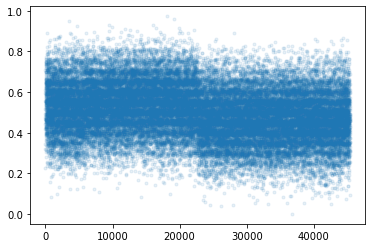

In [13]:
# With scikit-learn, we use the predict_proba method of the trained model to get the probabilities
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'],
                                     categories=['paid off', 'default'],
                                     ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']

outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]],
           alpha=0.1, marker='.')
knn.predict_proba(X)[:, 0]

loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]
print(loan_data['borrower_score'].describe())

## Tree Models

## A Simple Example
The package _scikit-learn_ has the class `DecisionTreeClassifier` to build a decsion tree model. The function `plotDecisionTree` from the dmba package can be used to visualize the tree.

In [14]:
loan3000 = pd.read_csv(LOAN3000_CSV)

loan3000.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3000 non-null   int64  
 1   outcome            3000 non-null   object 
 2   purpose_           3000 non-null   object 
 3   dti                3000 non-null   float64
 4   borrower_score     3000 non-null   float64
 5   payment_inc_ratio  3000 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 140.8+ KB


Figure 6-3. The rules for a simple tree model fit to the loan data


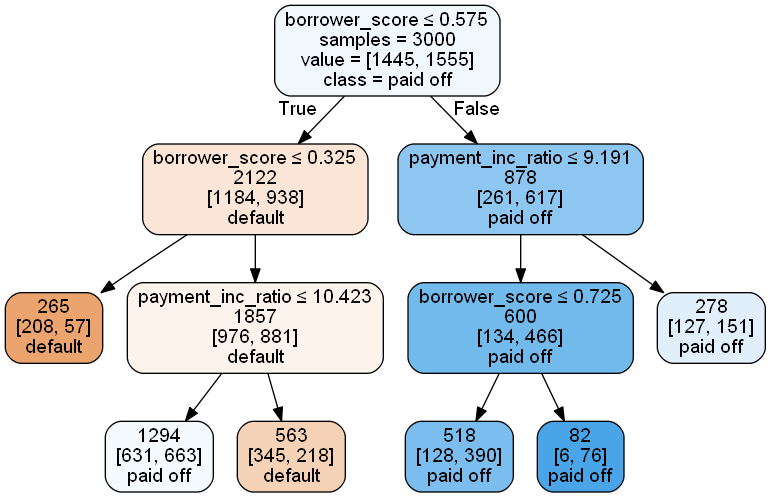

In [15]:
predictors = ['borrower_score', 'payment_inc_ratio']

outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy',
                                  min_impurity_decrease=0.003)
loan_tree.fit(X, y)
print("Figure 6-3. The rules for a simple tree model fit to the loan data")
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)

In [16]:
# The scikit-learn documentation describes how to create a text representation of a
# decision tree model. We included a convenience function in our dmba package:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


## The Recursive Partitioning Algorithm

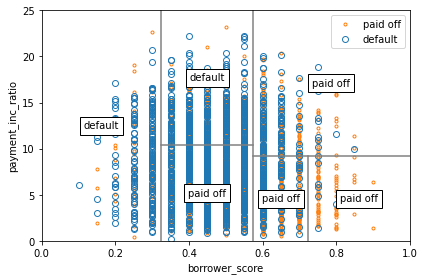

Figure 6-4. The first three rules for a simple tree model fit to the loan data|


In [17]:
fig, ax = plt.subplots(figsize=(6, 4))

loan3000.loc[loan3000.outcome=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
loan3000.loc[loan3000.outcome=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)

ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')


x0 = 0.575
x1a = 0.325; y1b = 9.191
y2a = 10.423; x2b = 0.725
ax.plot((x0, x0), (0, 25), color='grey')
ax.plot((x1a, x1a), (0, 25), color='grey')
ax.plot((x0, 1), (y1b, y1b), color='grey')
ax.plot((x1a, x0), (y2a, y2a), color='grey')
ax.plot((x2b, x2b), (0, y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')
    
plt.tight_layout()
plt.show()
print("Figure 6-4. The first three rules for a simple tree model fit to the loan data|")

## Measuring Homogeneity or Impurity

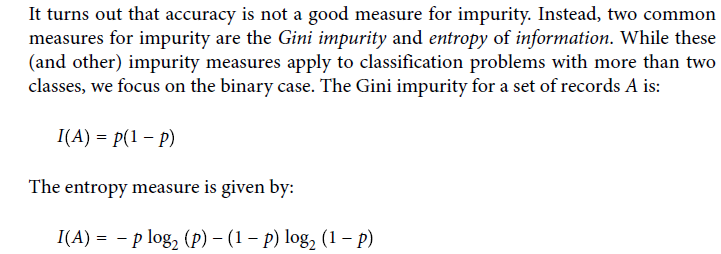

In [18]:
def entropyFunction(x):
    if x == 0: return 0
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)

def giniFunction(x):
    return x * (1 - x)

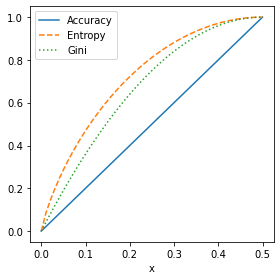

Figure 6-5. Gini impurity and entropy measures


In [19]:
x = np.linspace(0, 0.5, 50)
impure = pd.DataFrame({
    'x':x,
    'Accuracy': 2 * x,
    'Gini': [giniFunction(xi) / giniFunction(.5) for xi in x ],
    'Entropy': [entropyFunction(xi) for xi in x],
})

fig, ax = plt.subplots(figsize=(4, 4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Entropy', ax= ax, linestyle='--')
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')

plt.tight_layout()
plt.show()
print("Figure 6-5. Gini impurity and entropy measures")

## Bagging and the Random forest

### Random Forest
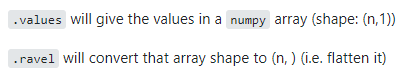

In [20]:
predictors = ['borrower_score','payment_inc_ratio']
outcome = ['outcome']

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1,
                           oob_score=True)
rf.fit(X, y.values.ravel())

print(rf.oob_decision_function_)

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]


In [21]:
n_estimator = list(range(20, 510, 5))
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n,
                               criterion='entropy', max_depth=5,
                               random_state=1, oob_score=True)
    rf.fit(X, y.values.ravel())
    oobScores.append(rf.oob_score_)

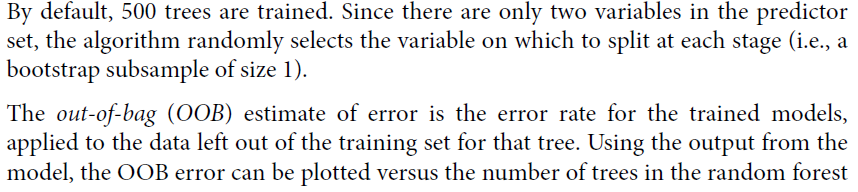

The RandomForestClassifier implementation has no easy way to get out-of-bag
estimates as a function of number of trees in the random forest. We can train a
sequence of classifiers with an increasing number of trees and keep track of the
oob_score_ values. This method is, however, not efficient

Figure 6-6. An example of the improvement in accuracy of the random forest with the addition of more trees


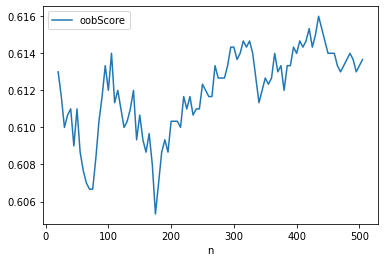

In [22]:
pd.DataFrame({
    'n': n_estimator,
    'oobScore': oobScores
}).plot(x='n', y='oobScore');
print("Figure 6-6. An example of the improvement in accuracy of the random forest with the addition of more trees")

In [23]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

,borrower_score,payment_inc_ratio,prediction
0,0.40,5.11135,default
1,0.40,5.43165,default
2,0.70,9.23003,paid off
3,0.40,2.33482,paid off
4,0.45,12.10320,default


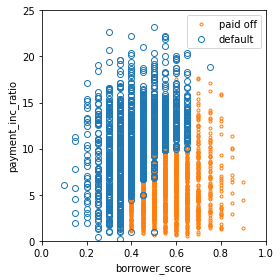

Figure 6-7. The predicted outcomes from the random forest applied to the loan default data


In [24]:
fig, ax = plt.subplots(figsize=(4, 4))

predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.', 
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)

ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()
print("Figure 6-7. The predicted outcomes from the random forest applied to the loan default data")

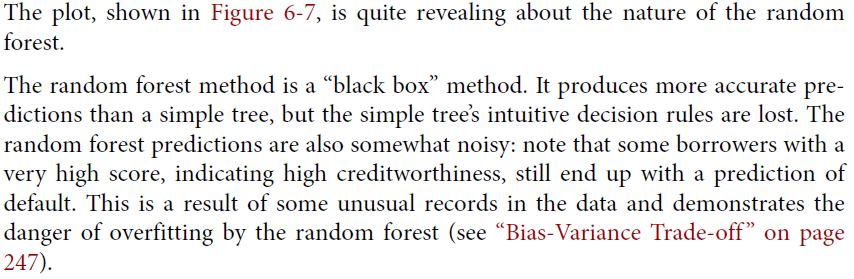

## Variable Importance
This is diffrent to R. The accuracy decrase is not available out of box.


In [25]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X, y)

rf_all_entropy = RandomForestClassifier(n_estimators=500, random_state=1,
                                       criterion='entropy')
print(rf_all_entropy.fit(X, y))

RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=1)


In [26]:
rf = RandomForestClassifier(n_estimators=500)
scores = defaultdict(list)

# Crossvalidate the scores on a number of diffrent random splits of the data
for _ in range(3):
    train_X, valid_X, train_y, valid_y, = train_test_split(X, y, test_size=0.3)
    
    rf.fit(train_X, train_y)
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))
    for column in X.copy():
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))
        scores[column].append((acc-shuff_acc)/acc)
print('Features sorted by their score: ')
print(sorted([(round(np.mean(score), 4), feat) for
              feat, score in scores.items()], reverse=True))

Features sorted by their score: 
[(0.0756, 'borrower_score'), (0.035, 'grade'), (0.0277, 'term_60 months'), (0.0124, 'annual_inc'), (0.0082, 'payment_inc_ratio'), (0.0031, 'dti'), (0.0027, 'purpose_small_business'), (0.0026, 'open_acc'), (0.002, 'purpose_credit_card'), (0.0012, 'purpose__small_business'), (0.001, 'emp_len__ > 1 Year'), (0.001, 'delinq_2yrs_zero'), (0.0007, 'home__RENT'), (0.0004, 'purpose_wedding'), (0.0003, 'purpose__home_improvement'), (0.0002, 'purpose_moving'), (0.0001, 'revol_bal'), (0.0001, 'purpose_vacation'), (0.0001, 'purpose_house'), (0.0001, 'purpose_home_improvement'), (0.0001, 'pub_rec_zero'), (0.0, 'purpose_major_purchase'), (-0.0001, 'home__OWN'), (-0.0002, 'purpose_medical'), (-0.0002, 'purpose__medical'), (-0.0002, 'emp_length'), (-0.0004, 'purpose__major_purchase'), (-0.0005, 'purpose__other'), (-0.0009, 'purpose_debt_consolidation'), (-0.001, 'purpose__debt_consolidation'), (-0.0013, 'purpose_other'), (-0.0013, 'loan_amnt'), (-0.0022, 'revol_util')]


In Python, the RandomForestClassifier collects information about feature importance
during training and makes it available with the field feature_importances_:

The “Gini decrease” is available as the feature_importance_ property of the fitted
classifier. Accuracy decrease, however, is not available out of the box for Python. We
can calculate it (scores) using the following code:

>There are two ways to measure variable importance:

• By the decrease in accuracy of the model if the values of a variable are randomly
permuted (type=1). Randomly permuting the values has the effect of removing
all predictive power for that variable. The accuracy is computed from the out-ofbag
data (so this measure is effectively a cross-validated estimate).

• By the mean decrease in the Gini impurity score (see “Measuring Homogeneity
or Impurity” on page 254) for all of the nodes that were split on a variable
(type=2). This measures how much including that variable improves the purity
of the nodes. This measure is based on the training set and is therefore less reliable
than a measure calculated on out-of-bag data.

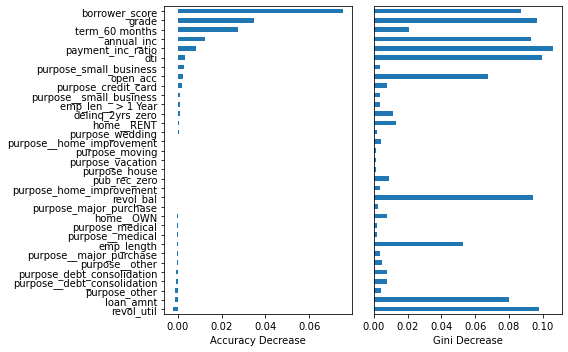

Figure 6-8. The importance of variables for the full model fit to the loan data


In [27]:
importances = rf_all.feature_importances_

df = pd.DataFrame({
    'feature': X.columns,
    'Accuracy decrease': [np.mean(scores[column]) for column in
                          X.columns],
    'Gini decrease': rf_all.feature_importances_,
    'Entropy decrease': rf_all_entropy.feature_importances_,
})
df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8, 5))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease',
             legend=False, ax=axes[0])
ax.set_ylabel('')
ax.set_xlabel('Accuracy Decrease')

ax = df.plot(kind='barh', x='feature', y='Gini decrease',
             legend=False, ax=axes[1])
ax.set_ylabel('')
ax.set_xlabel('Gini Decrease')
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()
print("Figure 6-8. The importance of variables for the full model fit to the loan data")

## Bosting

### XGBost

>In Python, xgboost has two different interfaces: a scikit-learn API and a more
functional interface like in R. To be consistent with other scikit-learn methods,
some parameters were renamed. For example, eta is renamed to learning_rate;
using eta will not fail, but it will not have the desired effect:

In [28]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = pd.Series([1 if o == 'default' else 0 for o in loan3000[outcome]])

xgb = XGBClassifier(objective='binary:logistic', subsample=.63,
                    use_label_encoder=False, eval_metric='error')
print(xgb.fit(X, y))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.63,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


In [29]:
xgb_df = X.copy()
xgb_df['prediction'] = ['default' if p == 1 else 'paid off' for p in xgb.predict(X)]
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 0]
print(xgb_df.head())

   borrower_score  payment_inc_ratio prediction  prob_default
0            0.40            5.11135   paid off      0.828856
1            0.40            5.43165    default      0.260156
2            0.70            9.23003    default      0.320805
3            0.40            2.33482   paid off      0.678005
4            0.45           12.10320    default      0.140204


>The predicted values can be obtained from the predict function, since there
are only two variables, plotted versus the predictors:

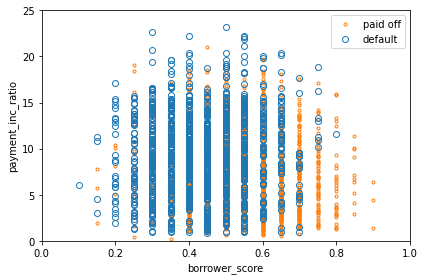

Figure 6-9. The predicted outcomes from XGBoost applied to the loan default data


In [32]:
fig , ax = plt.subplots(figsize=(6, 4))

xgb_df.loc[xgb_df.prediction=='paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)
xgb_df.loc[xgb_df.prediction=='default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)

ax.legend(['paid off', 'default']);
ax.set_xlim(0, 1)
ax.set_ylim(0, 25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

plt.tight_layout()
plt.show()
print("Figure 6-9. The predicted outcomes from XGBoost applied to the loan default data")

### Regularization : Avoiding Overfitting

This, however, is not the case for xgboost. Fit xgboost to the loan data for a training
set with all of the variables included in the model

We use the function train_test_split in Python to split the data set into training
and test sets

In [34]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = pd.Series([1 if o =='default' else 0 for o in loan_data[outcome]])

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                           reg_lambda=0, learning_rate=0.3, subsample=1,
                           use_label_encoder=False, eval_metric='error')
xgb_default.fit(train_X, train_y)

xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                           reg_lambda=1000, learning_rate=0.1, subsample=0.63,
                           use_label_encoder=False, eval_metric='error')

print(xgb_penalty.fit(train_X, train_y))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1000, scale_pos_weight=1, subsample=0.63,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)


The test set consists of 10,000 randomly sampled records from the full data, and the
training set consists of the remaining records. Boosting leads to an error rate of only
13.3% for the training set. The test set, however, has a much higher error rate of
35.3%. This is a result of overfitting: while boosting can explain the variability in the
training set very well, the prediction rules do not apply to new data.


In [35]:
pred_default = xgb_default.predict_proba(train_X)[:, 1]
error_default = abs(train_y - pred_default) > 0.5
print('default (train): ', np.mean(error_default))

pred_default = xgb_default.predict_proba(valid_X)[:, 1]
error_default = abs(valid_y - pred_default) > 0.5
print('default: ', np.mean(error_default))

pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]
error_penalty = abs(valid_y - pred_penalty) > 0.5
print('penalty: ', np.mean(error_penalty))

default (train):  0.126308641276668
default:  0.351
penalty:  0.3289


In Python, we can call the predict_proba method with the ntree_limit argument:

In [44]:
results = []
for ntree_limit in range(1, 250):
    train_default = xgb_default.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    train_penalty = xgb_penalty.predict_proba(train_X, ntree_limit=ntree_limit)[:, 1]
    pred_default = xgb_default.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    pred_penalty = xgb_penalty.predict_proba(valid_X, ntree_limit=ntree_limit)[:, 1]
    results.append({
        'iterations': ntree_limit,
        'default train': np.mean(abs(train_y - train_default) > 0.5),
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),
    })

results = pd.DataFrame(results);
print(results.head())

C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instea

C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instea

C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instea

C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instea

C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instea

C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
C:\Users\batara\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


   iterations  default train  penalty train  default test  penalty test
0           1       0.339766       0.339822        0.3514        0.3524
1           2       0.330570       0.339907        0.3488        0.3444
2           3       0.326326       0.341831        0.3425        0.3458
3           4       0.323807       0.339200        0.3419        0.3453
4           5       0.319846       0.338747        0.3399        0.3447


We can use the pandas plot method to create the line graph. The axis returned from
the first plot allows us to overlay additional lines onto the same graph. This is a pattern
that many of Python’s graph packages support

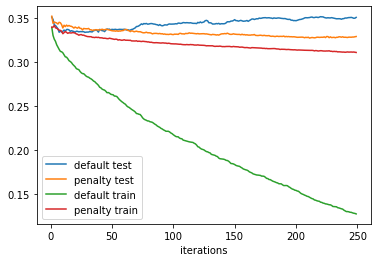

Figure 6-10. The error rate of the default XGBoost versus a penalized version of XGBoost


In [48]:
ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)
plt.show()
print("Figure 6-10. The error rate of the default XGBoost versus a penalized version of XGBoost")

### Hyperparameters and Cross-Validation

In [50]:
idx = np.random.choice(range(5), size=len(X), replace=True)
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]): #We use the function itertools.product from the Python standard 
    #library to create all possible combinations of the two hyperparameters.
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=250,
                       max_depth=max_depth, learning_rate=eta,
                       use_label_encoder=False, eval_metric='error')
    
    cv_error = []
    for k in range(5):
        fold_idx = idx == k
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]
        
        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:, 1]
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5))
    error.append({
        'eta': eta,
        'max_depth': max_depth,
        'avg_error': np.mean(cv_error)
    })
    print(error[-1])
errors = pd.DataFrame(error)
print(errors)

{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.32862108365901355}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.3351424737865005}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.3443247998767514}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.3394523024629869}
{'eta': 0.5, 'max_depth': 6, 'avg_error': 0.36936935337418214}
{'eta': 0.5, 'max_depth': 9, 'avg_error': 0.37497301345171363}
{'eta': 0.9, 'max_depth': 3, 'avg_error': 0.3576977506113394}
{'eta': 0.9, 'max_depth': 6, 'avg_error': 0.3891137057668371}
{'eta': 0.9, 'max_depth': 9, 'avg_error': 0.3850709534879809}
   eta  max_depth  avg_error
0  0.1          3   0.328621
1  0.1          6   0.335142
2  0.1          9   0.344325
3  0.5          3   0.339452
4  0.5          6   0.369369
5  0.5          9   0.374973
6  0.9          3   0.357698
7  0.9          6   0.389114
8  0.9          9   0.385071


Since we are fitting 45 total models, this can take a while. The errors are stored as a
matrix with the models along the rows and folds along the columns. Using the function
rowMeans, we can compare the error rate for the different parameter sets:

Cross-validation suggests that using shallower trees with a smaller value of eta/learn
ing_rate yields more accurate results. Since these models are also more stable, the
best parameters to use are eta=0.1 and max_depth=3 (or possibly max_depth=6).

In [53]:
print(errors.pivot_table(index='eta', columns='max_depth', values='avg_error') * 100)

max_depth          3          6          9
eta                                       
0.1        32.862108  33.514247  34.432480
0.5        33.945230  36.936935  37.497301
0.9        35.769775  38.911371  38.507095


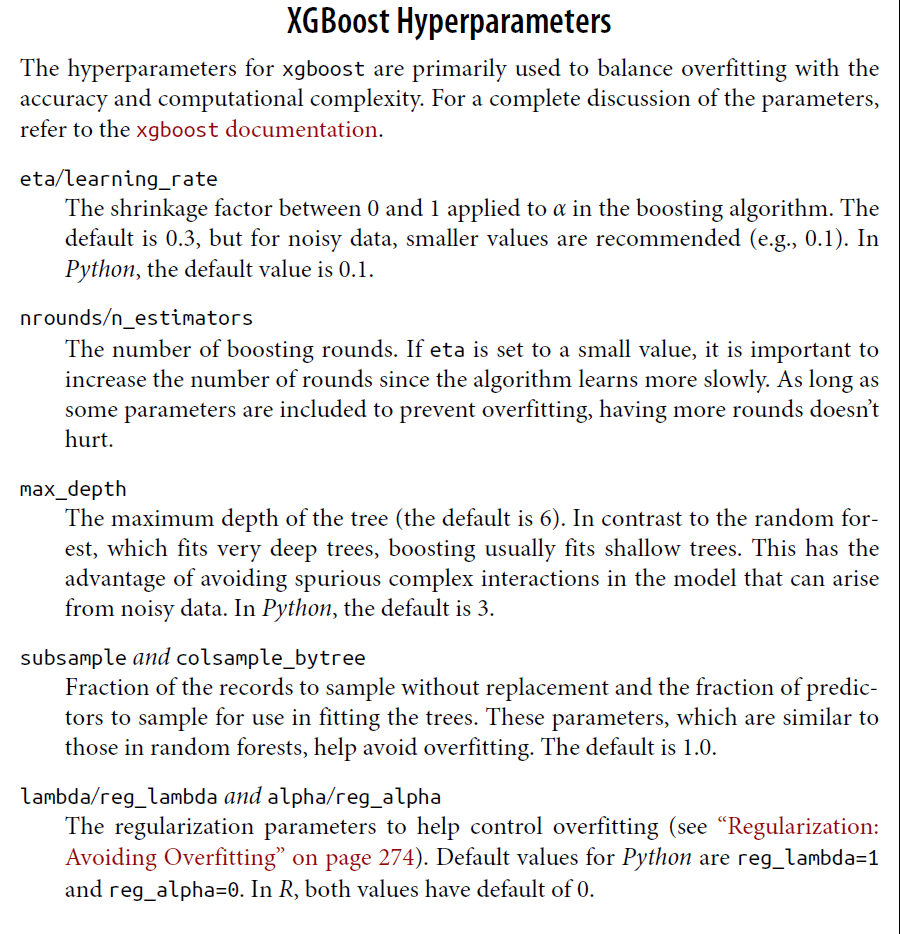
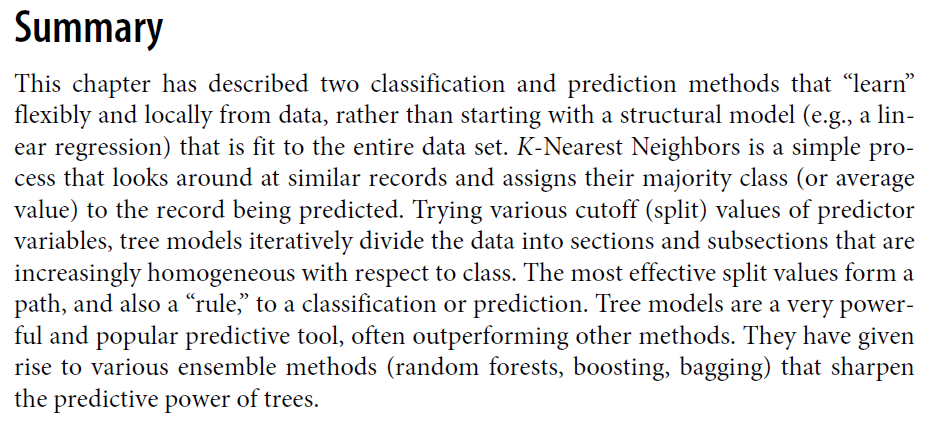